# Twitter API Introduction

In this tutorial, we will be praciticing querying the Twitter API in python.

We'll also be using Tweepy - which is a python wrapper that allows us to use the Twitter API. Of course, the Twitter API can be accessed directly as well, but Tweepy has a few extras that makes getting Tweets just a bit easier. 


### Resources and Links

http://docs.tweepy.org/en/latest/


In [1]:
import json
import networkx as nx
import tweepy
# conda install -c conda-forge tweepy
import numpy as np
import matplotlib.pyplot as plt

### Getting New Tweets

Before you can access the API, you'll need to create a developer account and create/register your application wtih Twitter to get the necessary authentication keys. 

https://developer.twitter.com/

In [2]:
info = {"api_key": "",
        "api_key_secret": "",
        "bearer_token" : "",
        "access_token": "",
        "access_token_secret": ""}

My app: https://developer.twitter.com/en/portal/projects/1481027098718334976/apps

In [3]:
info = json.loads(open('../.secrets/twitter_api.json').read())

In [4]:
# Authenticate using our credentials

client = tweepy.Client(
    consumer_key       = info["api_key"],
    consumer_secret    = info["api_key_secret"],
    bearer_token       = info["bearer_token"],
    access_token       = info["access_token"],
    access_token_secret= info["access_token_secret"],
    wait_on_rate_limit = True
)

`search_all_tweets` - academic research mode only  
https://developer.twitter.com/en/products/twitter-api/academic-research  
https://developer.twitter.com/en/docs/twitter-api/tweets/search/introduction  
https://docs.tweepy.org/en/stable/client.html#search-tweets  

In [54]:
covid_tweets = client.search_recent_tweets(
    query="covid",
    max_results=10,
)

In [55]:
type(covid_tweets)

tweepy.client.Response

In [65]:
for tweet in covid_tweets[0]:
    print(type(tweet))
    print(tweet.data)
    break

<class 'tweepy.tweet.Tweet'>
{'id': '1493720920002904064', 'text': 'RT @HeartlandSignal: WI State Sen. Felzkowski (R), presenting a natural immunity bill, says she has had both delta and omicron infections.…'}


In [64]:
len(covid_tweets),covid_tweets[1], covid_tweets[2]

(4, {}, [])

In [8]:
covid_tweets[3]

{'newest_id': '1493712137063215106',
 'oldest_id': '1493712133837955072',
 'result_count': 10,
 'next_token': 'b26v89c19zqg8o3fpe765pscj3u4qa3zahma79k2ok48t'}

https://developer.twitter.com/en/docs/twitter-api/fields

In [9]:
fields = "created_at,public_metrics"

In [66]:
covid_tweets_field = client.search_recent_tweets(
    query="covid",
    max_results=10,
    tweet_fields=fields
)

In [67]:
for tweet in covid_tweets_field[0]:
    print(tweet.data)
    print(tweet['created_at'])
    break

{'created_at': '2022-02-15T23:10:49.000Z', 'id': '1493724510301790214', 'text': '@nihilistcute Hahahahahahahahha esse sou eu no pós covid. Não lembro de nada e uso o coiso, a coisa...', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}}
2022-02-15 23:10:49+00:00


### Formulating a new query + saving data

https://developer.twitter.com/en/docs/tutorials/building-high-quality-filters

In [68]:
expansions = "author_id,referenced_tweets.id.author_id"

In [16]:
tweets_field_exp = client.search_recent_tweets(
    query="#StopAsianHate",
    max_results=10,
    tweet_fields=fields,
    expansions=expansions
)

In [69]:
### Saving data to your machine
tweet_data_dict = [tweet.data for tweet in tweets_field_exp[0]]
with open("query1.json", "w") as outfile:
    json.dump(tweet_data_dict, outfile, indent=4)


### Getting re-tweeters

https://docs.tweepy.org/en/stable/client.html#tweet-lookup

In [48]:
retweeters = []
for tweet in tweet_data_dict:
    rt = tweet.get('referenced_tweets')
    if rt and rt[0]['type'] in ['retweeted','quoted']:
        ref_tweet = client.get_tweet(
            id=rt[0]['id'],
            expansions='author_id'
        )
        retweeters.append(
            [ tweet.get('author_id'), ref_tweet[0].data.get('author_id')]
        )

In [49]:
retweeters

[['2165807125', '4079305401'],
 ['1158792198948904962', '133836828'],
 ['1278132266091245569', '2283000038'],
 ['1479851435210817546', '1488913117'],
 ['529718133', '745540429'],
 ['2165807125', '63821681'],
 ['4141511834', '745540429'],
 ['908561864396726272', '24004575']]

In [50]:
connections = np.array(retweeters).flatten()

nodes = list(set(np.array(retweeters).flatten()))

len(connections), len(nodes)

(16, 14)

In [51]:
TW_G = nx.DiGraph()
TW_G.add_nodes_from(nodes)
TW_G.add_edges_from(retweeters)

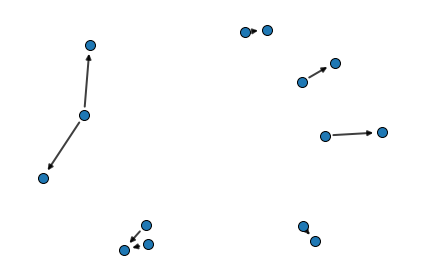

In [52]:
ax = plt.subplots()

pos = nx.spring_layout(TW_G, seed=260)
nx.draw_networkx_edges(TW_G, pos, alpha=0.75, width=2)
nx.draw_networkx_nodes(TW_G, pos, node_size=100).set_edgecolor('black')

plt.tight_layout()
plt.axis("off")
plt.show()